In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# from torchsummary import summary

from torchvision import transforms

from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Conv2d
from torch.nn import Flatten
from torch.nn import MaxPool2d
from torch.nn import LeakyReLU
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss

from torch.optim import Adam

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight

In [2]:
class All_mias_Dataset_detection(Dataset):
    """Mias mammography dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file).iloc[:,3:]
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = {
            'CALC': [1,0,0,0,0,0],
            'CIRC': [0,1,0,0,0,0],
            'ARCH': [0,0,1,0,0,0],
            'SPIC': [0,0,0,1,0,0],
            'MISC': [0,0,0,0,1,0],
            'ASYM': [0,0,0,0,0,1],
             0: 'CALC',
             1: 'CIRC',
             2: 'ARCH',
             3: 'SPIC',
             4: 'MISC',
             5: 'ASYM',
        }


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0] + ".pgm")
        image = io.imread(img_name)
        image = np.asarray(image, dtype=np.float32)
        
        detection_points = self.data.iloc[idx,4:6]
        detection_points = np.array(detection_points, dtype=np.float32)

        annotation = self.data.iloc[idx,2]
        annotation = np.array(self.annotations[annotation], dtype=np.float32)

        sample = (image,detection_points,annotation)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class All_mias_Dataset_classification(Dataset):
    """Mias mammography dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file).iloc[:,3:]
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = {
            'CALC': [1,0,0,0,0,0],
            'CIRC': [0,1,0,0,0,0],
            'ARCH': [0,0,1,0,0,0],
            'SPIC': [0,0,0,1,0,0],
            'MISC': [0,0,0,0,1,0],
            'ASYM': [0,0,0,0,0,1],
             0: 'CALC',
             1: 'CIRC',
             2: 'ARCH',
             3: 'SPIC',
             4: 'MISC',
             5: 'ASYM',
        }


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        detection_points = self.data.iloc[idx,4:6]
        detection_points = np.array(detection_points, dtype=np.float32)

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0] + ".pgm")
        image = io.imread(img_name)
        image = np.asarray(image, dtype=np.float32)
        image = np.reshape(image, (1,1024,1024))
        x1,y1,x2,y2 = self.calc_mask_points(detection_points[0], detection_points[1])
        mask = self.create_mask(x1,y1,x2,y2,image)
        mask = np.asarray(mask, dtype=np.float32)
        mask = np.reshape(mask, (1,256,256))
        
        annotation = self.data.iloc[idx,2]
        annotation = np.array(self.annotations[annotation], dtype=np.float32)

        sample = (mask,detection_points,annotation)

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def create_mask(self, x1,y1,x2,y2,image):
        MASK_SIZE = 128
        mask = np.zeros((x2-x1,y2-y1))
        for i in range(2*MASK_SIZE):
            for j in range(2*MASK_SIZE):
                if i + y1 >= 1023 or j + x1 >= 1023:
                    mask[i][j] = 0
                elif i + y1 <= 0 or j + x1 <= 0:
                    mask[i][j] = 0
                else:
                    mask[i][j] = image[0][i+y1][j+x1]
        return mask


    def calc_mask_points(self, x, y):
        MASK_SIZE = 128
        y = 1024 - y
        x1 = int(x - MASK_SIZE)
        y1 = int(y - MASK_SIZE)
        x2 = int(x + MASK_SIZE)
        y2 = int(y + MASK_SIZE)
        return x1,y1,x2,y2


In [4]:
class Transform_data_detection(object):

    def __call__(self,sample):
        image, detection_points, annotation = sample[0], sample[1], sample[2]
        image = image / 255
        return (image,detection_points,annotation)
    

class Transform_data_classification(object):

    def __call__(self,sample):
        image, detection_points, annotation = sample[0], sample[1], sample[2]
        image = image / 255
        image = image - np.mean(image)
        return (image,detection_points,annotation)


class ToTensor(object):
    
    def __call__(self, sample):
        image, detection_points, annotation = sample[0], sample[1], sample[2]
        return (torch.from_numpy(image), torch.from_numpy(detection_points),torch.from_numpy(annotation))

In [5]:
class Detector(Module):

	def __init__(self):
		super(Detector, self).__init__()

		self.conv1 = Sequential(
			Conv2d(in_channels=1,out_channels=16,kernel_size=3),
			LeakyReLU(),
			MaxPool2d(kernel_size=3,stride=3),
			Conv2d(in_channels=16,out_channels=32,kernel_size=3),
			LeakyReLU(),
			MaxPool2d(kernel_size=3,stride=3),
			Conv2d(in_channels=32,out_channels=64,kernel_size=3),
			LeakyReLU(),
			MaxPool2d(kernel_size=3,stride=3),
			Flatten()
		)

		self.regressor = Sequential(
			Linear(82944, 1024),
			LeakyReLU(),
			Linear(1024, 512),
			LeakyReLU(),
			Linear(512, 256),
			LeakyReLU(),
			Linear(256, 64),
			LeakyReLU(),
			Linear(64, 2),
			LeakyReLU()
		)


	def forward(self, x):
		detection_conv = self.conv1(x)
		points = self.regressor(detection_conv)
		return points


In [6]:
class Classifier(Module):

	def __init__(self, class_num):
		super(Classifier, self).__init__()
		self.class_num = class_num

		self.conv1 = Sequential(
			Conv2d(in_channels=1,out_channels=16,kernel_size=3),
			ReLU(),
			MaxPool2d(kernel_size=2,stride=2),
			Conv2d(in_channels=16,out_channels=32,kernel_size=3),
			ReLU(),
			MaxPool2d(kernel_size=2,stride=2),
			Conv2d(in_channels=32,out_channels=64,kernel_size=3),
			ReLU(),
			MaxPool2d(kernel_size=2,stride=2),
			Flatten()
		)

		self.classifier = Sequential(
			Linear(57600, 4096),
			ReLU(),
			Dropout(),
			Linear(4096, 512),
			ReLU(),
			Dropout(),
			Linear(512, 128),
			ReLU(),
			Dropout(),
			Linear(128, 64),
			ReLU(),
			Dropout(),
			Linear(64, self.class_num),
			Sigmoid()
		)


	def forward(self, x):
		Classifier_conv = self.conv1(x)
		label = self.classifier(Classifier_conv)
		return label

In [7]:
detector = Detector()
classifier = Classifier(6)

In [19]:
summary(detector.cuda(), (1, 1024, 1024))

summary(classifier.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 16, 1022, 1022]             160
         LeakyReLU-2       [-1, 16, 1022, 1022]               0
         MaxPool2d-3         [-1, 16, 340, 340]               0
            Conv2d-4         [-1, 32, 338, 338]           4,640
         LeakyReLU-5         [-1, 32, 338, 338]               0
         MaxPool2d-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 110, 110]          18,496
         LeakyReLU-8         [-1, 64, 110, 110]               0
         MaxPool2d-9           [-1, 64, 36, 36]               0
          Flatten-10                [-1, 82944]               0
           Linear-11                 [-1, 1024]      84,935,680
        LeakyReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
        LeakyReLU-14                  [

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             160
              ReLU-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          18,496
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
          Flatten-10                [-1, 57600]               0
           Linear-11                 [-1, 4096]     235,933,696
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                  [

In [8]:
all_mias_dataset_detection = All_mias_Dataset_detection(csv_file="Info_overtrain_data.txt",
                                root_dir="all-mias",
                                transform=transforms.Compose([
                                        Transform_data_detection(),
                                        ToTensor()
                                ]))

all_mias_dataset_classification = All_mias_Dataset_classification(csv_file="Info_without_NORM.txt",
                                root_dir="all-mias",
                                transform=transforms.Compose([
                                        Transform_data_classification(),
                                        ToTensor()
                                ]))

In [9]:
is_class_weights_computed = False
if not is_class_weights_computed:
    data_to_compute_class_weights = [int(torch.argmax(i[2])) for i in all_mias_dataset_classification]
    class_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        y=data_to_compute_class_weights,
                                        classes = np.unique(data_to_compute_class_weights)
                                        )
                                        
    class_weights = np.array(class_weights, dtype=np.float32)
    class_weights = torch.from_numpy(class_weights)
    is_class_weights_computed = True
class_weights


tensor([0.7346, 0.8264, 1.0439, 1.0439, 1.3222, 1.3222])

In [10]:
# 0.7346, 0.8264, 1.0439, 1.0439, 1.3222, 1.3222
class_weights = [0.5346, 0.8264, 1.0439, 1.0439, 1.2222, 1.3222]
class_weights = np.array(class_weights, dtype=np.float32)
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([0.5346, 0.8264, 1.0439, 1.0439, 1.2222, 1.3222])

In [11]:
BATCH_SIZE_DETECTION = 1
circLossFunc = MSELoss()
opt_detection = Adam(detector.parameters())
train_detection, test_detection = torch.utils.data.random_split(all_mias_dataset_detection, [0.9, 0.1])
dataloader_detection_train = DataLoader(train_detection, batch_size=BATCH_SIZE_DETECTION, shuffle=False, num_workers=0)

BATCH_SIZE_CLASSIFICATION = 4
loss_func = CrossEntropyLoss(weight=class_weights)
loss_history = list()
opt_classification = Adam(classifier.parameters(), lr=0.001)
train_classification, test_classification = torch.utils.data.random_split(all_mias_dataset_classification, [0.9, 0.1])
dataloader_classification_train = DataLoader(train_classification, batch_size=BATCH_SIZE_CLASSIFICATION, shuffle=True, num_workers=0)

c:\Users\szymo\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:414: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [12]:
epochs = 10
step_total = train_detection.__len__()/BATCH_SIZE_DETECTION
for epoch in range(epochs):
    step = 0
    detector.train()
    for (image, detection, annotation) in dataloader_detection_train:
        step += 1
        image = np.reshape(image, (BATCH_SIZE_DETECTION,1,1024,1024))
        pred = detector(image)
        circ_loss = circLossFunc(pred[0], detection)
        print('epoch',epoch+1,'/',epochs,':','step',step,'/',step_total,'loss:',float(circ_loss))
        if circ_loss < 25:
            break
        opt_detection.zero_grad()
        circ_loss.backward()
        opt_detection.step()
    if circ_loss < 25:
            break

c:\Users\szymo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 / 10 : step 1 / 5.0 loss: 122567.78125
epoch 1 / 10 : step 2 / 5.0 loss: 227914.296875
epoch 1 / 10 : step 3 / 5.0 loss: 214178.59375
epoch 1 / 10 : step 4 / 5.0 loss: 541690.875
epoch 1 / 10 : step 5 / 5.0 loss: 127717.515625
epoch 2 / 10 : step 1 / 5.0 loss: 96724.359375
epoch 2 / 10 : step 2 / 5.0 loss: 143162.0625
epoch 2 / 10 : step 3 / 5.0 loss: 63803.88671875
epoch 2 / 10 : step 4 / 5.0 loss: 142906.546875
epoch 2 / 10 : step 5 / 5.0 loss: 198763.171875
epoch 3 / 10 : step 1 / 5.0 loss: 157076.21875
epoch 3 / 10 : step 2 / 5.0 loss: 1060.7279052734375
epoch 3 / 10 : step 3 / 5.0 loss: 6285.6728515625
epoch 3 / 10 : step 4 / 5.0 loss: 216100.96875
epoch 3 / 10 : step 5 / 5.0 loss: 24845.447265625
epoch 4 / 10 : step 1 / 5.0 loss: 26021.40234375
epoch 4 / 10 : step 2 / 5.0 loss: 55303.29296875
epoch 4 / 10 : step 3 / 5.0 loss: 43031.4375
epoch 4 / 10 : step 4 / 5.0 loss: 238392.59375
epoch 4 / 10 : step 5 / 5.0 loss: 18372.9140625
epoch 5 / 10 : step 1 / 5.0 loss: 21769.34

In [13]:
epochs = 1
step_total = train_classification.__len__()/BATCH_SIZE_CLASSIFICATION
for epoch in range(epochs):
    step = 0
    classifier.train()
    for (image, detection, annotation) in dataloader_classification_train:
        step += 1
        image = np.reshape(image, (BATCH_SIZE_CLASSIFICATION,1,256,256))
        pred = classifier(image)
        loss = loss_func(pred, annotation)
        loss_history.append(loss)
        print('epoch',epoch+1,'/',epochs,':','step',step,'/',step_total,'loss:',float(loss))
        opt_classification.zero_grad()
        loss.backward()
        opt_classification.step()
        if step == 1:
            break

epoch 1 / 1 : step 1 / 27.0 loss: 1.5694687366485596


In [14]:
def prepare_data_test(data_file_name):
    raw_image = io.imread(data_file_name) 
    raw_image = np.array(raw_image, dtype=np.float32)
    image = raw_image
    image = np.array(image, dtype=np.float32)
    image /= 255
    image = np.reshape(image, (1,1,1024,1024))
    image = torch.from_numpy(image)
    return image, raw_image

def show_prediction(pred, raw_image):
    x, y = int(pred[0][0]), int(pred[0][1])
    print('x:', x, 'y:', y)
    x1,y1,x2,y2 = calc_mask_points(x, y)
    raw_image = np.reshape(raw_image, (1,1024,1024))
    mask = create_mask(x1,y1,x2,y2,raw_image)
    plt.imshow(mask, interpolation='nearest', cmap='gray')
    plt.show()
    return mask, [[x1,y1],[x2,y2]]

def create_mask(x1,y1,x2,y2,image):
    MASK_SIZE = 128
    mask = np.zeros((x2-x1,y2-y1))
    for i in range(2*MASK_SIZE):
        for j in range(2*MASK_SIZE):
            if i + y1 >= 1023 or j + x1 >= 1023:
                mask[i][j] = 0
            elif i + y1 <= 0 or j + x1 <= 0:
                mask[i][j] = 0
            else:
                mask[i][j] = image[0][i+y1][j+x1]           
    return mask

def calc_mask_points(x, y):
    MASK_SIZE = 128
    y = 1024 - y
    x1 = x - MASK_SIZE
    y1 = y - MASK_SIZE
    x2 = x + MASK_SIZE
    y2 = y + MASK_SIZE
    return x1,y1,x2,y2

x: 525 y: 423


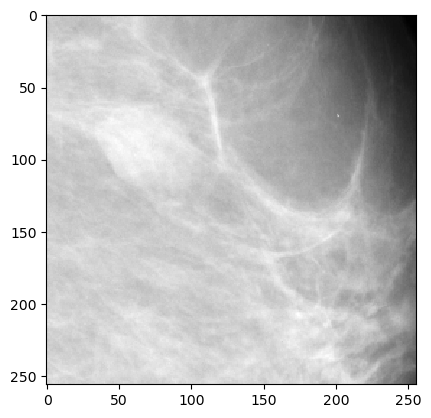

SPIC


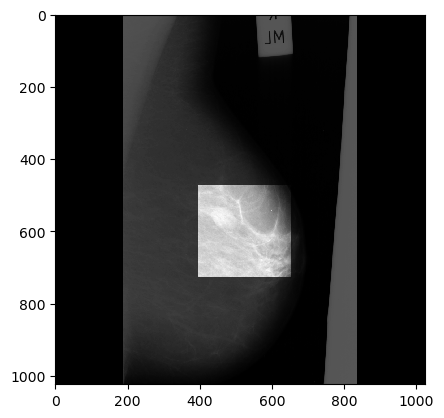

In [15]:
image, raw_image = prepare_data_test('all-mias//mdb012.pgm')
detector.eval()
pred = detector(image)      
mask, points = show_prediction(pred, raw_image)

mask = np.asarray(mask, dtype=np.float32)
mask = np.reshape(mask, (1,1,256,256))
mask = torch.from_numpy(mask)

pred_class = classifier(mask)
label = all_mias_dataset_detection.annotations[int(torch.argmax(pred_class))]
print(label)

raw_image /= 4
points[0][0],points[0][1],points[1][0],points[1][1] = int(points[0][0]),int(points[0][1]), int(points[1][0]), int(points[1][1])
for k in range(points[0][0],points[1][0]):
    for i in range(points[0][1],points[1][1]):
        if i >= 0 and k >= 0 and i <= 1024 and k <= 1024:
            raw_image[i][k] *= 4
            
plt.imshow(raw_image, interpolation='nearest', cmap='gray')
plt.show()
